# NG width analysis # 
Author: Marjolein Heidotting

In [5]:
import Zip
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import math
import pickle

# Channels in the detector
det_ch = { 'tpc': list(range(0, 247+1)), 'veto': list(range(248, 253+1)), 
          'sum_wv': [254], 'busy_on': [255], 'busy_off': [256],
          'hev_on': [257], 'hev_off': [258], 'muon_veto_trigger': [259], } 
n_channels = 260

# The data files
NG = Zip.ReadZipped("/data/nikhefproject/data/xenon1t/NG") # Neutron data
Rn220 = Zip.ReadZipped("/data/nikhefproject/data/xenon1t/Rn220") # Rn-220 data

In [9]:
#importing the neutron data
with open('NG_data.p', 'rb') as fp:
    NG_data = pickle.load(fp)

In [10]:
#Joey's peakfinder function

def Peaks(pulse, printall):
    
    # The standard variables
    q = 0
    left_t, right_t = 0, 0
    baseline = 16382.
    std = 2.3
    ch = pulse.channel
    wave = pulse.raw_data
    
    # The index for the minimum
    minindex = len(wave)
    
    # Variables for the average, the ratio and the slope
    avfound = 0
    samplelist = [wave[0]]
    ratio = 1
    slope = 0
    sw = 0

    s = np.std(wave)
    delta = baseline - np.min(wave)
    if min(s, delta) > 5*std:
        for samples in enumerate(wave):
            base_sub = samples[1] - baseline
            if abs(base_sub) > 5*std:
                q = q + base_sub
            
            # Compute the average of the previous samples
            av = np.average(samplelist)
            
            # left_t is assigned when a significant deviation from the average is recorded
            if abs(samples[1] - av) > 20 and left_t == 0:
                left_t = samples[0]
                
                # The sample value at left_t is kept for the slope calculation
                leftsample = samplelist[-1]
                if printall:
                    print("left_t here")
                avfound = av
             
            # Find the index for the minimum
            if samples[1] == np.min(wave):
                minindex = samples[0]

            # right_t is assigned in a similar way as left_t
            if abs(samples[1] - avfound) < 20 and samples[0] > minindex and right_t == 0: 
                right_t = samples[0]
                if printall:
                    print("right_t here")
                
            # Add the current sample to the sample list
            samplelist.append(samples[1])
            
            # A printing section in case the raw data needs to be analysed
            if printall:
                print(samples)
                print("Average:", av)
                if left_t == 0:
                    print("Average difference:", abs(samples[1] - av))
                else:
                    print("Average difference:", abs(samples[1] - avfound))
                print()
        
        # Calculate the ratio and the slope
        ratio = np.min(wave)/int(avfound)
        delta_x = minindex - left_t
        if delta_x != 0:
            slope = (np.min(wave) - leftsample)/delta_x
        
    else:
        baseline = np.average(wave)
        std = s
    width = right_t - left_t
    if width != 0:
        sw = slope/width
        if -q/width < 3*std or ratio >= 0.99:
            q = 0
    return (ch, q, width, pulse.left+left_t, sw)

In [23]:
def width_finder(boundary, eventnum, selected):
    """
    Finding the widths of the peaks in a certain event
    
    @param eventnum: The number of the events that is being looked at
    
    @type widthlist: list
    @param widthlist: contains the widths of the peaks in the given event
    
    @type returnlist: list
    @param returnlist: [[eventnumber], [s1 peaks], [s2 peaks]]
    """
    
    #setting
    event = 0
    returnlist = []
    widthlist = []
    
    if selected == False:
        for eventn in range(eventnum):
            print("currently working on event", eventn)
            returnlist.append([event, [],[]])
            
            event = NG.get_single_event(eventn)
        
            for p in event.pulses: #looping over pulses
                result = Peaks(p, False)
            
            
                if result[2] != 0:
                    widthlist.append(result[2])
                    if result[2]<boundary:#and len(returnlist[-1][1]) == 0:
                        returnlist[-1][1].append(result[2])
                    else:
                        returnlist[-1][2].append(result[2])            
            
            
    
    if selected == True:
        #looping over all selected events
        for event in NG_data:
        
            print("currently working on event", event['event'])
            returnlist.append([event, [],[]])
            
            event = NG.get_single_event(event['event'])
        
            for p in event.pulses: #looping over pulses
                result = Peaks(p, False)
            
            
                if result[2] != 0:
                    widthlist.append(result[2])
                    if result[2]<boundary:#and len(returnlist[-1][1]) == 0:
                        returnlist[-1][1].append(result[2])
                    else:
                        returnlist[-1][2].append(result[2])
                
                

    return returnlist, widthlist





### Analysing raw event widths ###

In [ ]:
#all widths for 1000 events with the boundary between s1 and s2 at 100, for the raw events
masterlist = width_finder(100, 1000, False)

In [153]:
#raw events
#Making a histogram of the widths of all peaks in all first 1000 events
hist = masterlist[1]
n, bins, patches = plt.hist(hist, 25, range=(-0.5,50.5))
plt.xlabel('Peak width')
plt.yscale('log')
plt.ylabel('Entries')
#plt.savefig("NG_peak_width_unselected.png")#option to save the figure

### Peak widths after selection ###

In [ ]:
#all widths for 1000 events with the boundary between s1 and s2 at 100, for the selected events
masterlist = width_finder(100, 1000, True)

In [ ]:
#selected events
#Making a histogram of the widths of all peaks from selected events in all first 1000 events
hist = masterlist[1]
n, bins, patches = plt.hist(hist, 25, range=(-0.5,50.5))
plt.xlabel('Peak width')
plt.yscale('log')
plt.ylabel('Entries')
#plt.savefig("NG_peak_width_selected.png")#option to save the figure

Based on the previous histogram, we'll set the difference in widths of the S1 and S2 peak to 100

# Using Zhuoran's data for correlation plot + s1/s2 order correction #

In [26]:
#print two events from each source
print("NG event", NG_data[200])

NG event {'event': 317, 's1': 57612.0, 's2': 480338.0, 's1_position': 100055, 's2_position': 130548}


In [27]:
#check for events in which the s2 occurs before the s1
reverse_eventsNG = []

for event in NG_data:
    if event['s2_position'] < event['s1_position']:
        #print(event['event'])
        reverse_eventsNG.append(event)
        #NG_data.remove(event)
        
reverseNG = len(reverse_eventsNG)
print("There are ", len(reverse_eventsNG), " events in the neutron data where the s2 occured before the s1")



There are  414  events in the neutron data where the s2 occured before the s1


In [28]:
#Removing events where S2 occurs before S1
for event in reverse_eventsNG:
    NG_data.remove(event)
    

In [83]:
#Checking to see how many of the events are used
#making a list of all events with valid S1s and S2s for the neutron data
eventlist = []

for event in NG_data:
    eventlist.append(event['event'])
print("Number of used events", len(eventlist))
print("Number of registered events", max(eventlist))
print("The fraction of events that is left after filtering ", len(eventlist)/max(eventlist))

Number of used events 7076
Number of registered events 10000
The fraction of events that is left after filtering  0.7076


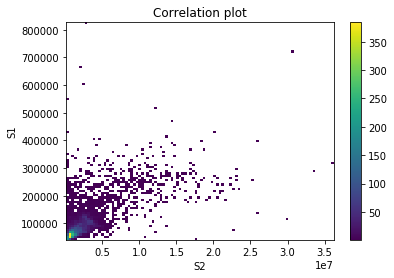

In [85]:
#Neutron correlation plot
#setting the number of events to loop over
eventnum = len(NG_data)

s1list = []
s2list = []

#looping over all events and putting them in collective lists
for event in NG_data:
    s1list.append(event['s1'])
    s2list.append(event['s2'])
    
#print(s1list)
colors = (0,0,0)
area = np.pi*3

s1 = np.array(s1list)
s2 = np.array(s2list)

# Plot
plt.hist2d(s2,s1,bins=(100,100),cmin=1) #making the plot, leaving out empty bin
plt.title('Correlation plot')
plt.xlabel('S2')
plt.ylabel('S1')
plt.colorbar()
plt.show()


In [30]:
#Making a list of the accumulated ADCs of the selected peaks in 
NGwidthlist = []

for event in NG_data:
    NGwidthlist.append(event['s1'])
    NGwidthlist.append(event['s2'])
print(NGwidthlist)

[110469.0, 1311152.0, 61104.0, 985845.0, 53347.0, 1209602.0, 54332.0, 578029.0, 71648.0, 1189616.0, 64816.0, 1179503.0, 60423.0, 1163309.0, 57547.0, 1504364.0, 104887.0, 1637888.0, 63198.0, 1500644.0, 61628.0, 1847556.0, 65685.0, 2515066.0, 54938.0, 1078481.0, 50223.0, 816229.0, 63580.0, 1163480.0, 117171.0, 2425303.0, 48071.0, 1089164.0, 75142.0, 2020179.0, 46160.0, 428721.0, 53105.0, 335658.0, 64182.0, 489103.0, 47677.0, 459024.0, 74782.0, 3343341.0, 57673.0, 979094.0, 76134.0, 2994851.0, 52822.0, 868745.0, 52276.0, 525668.0, 64238.0, 1212759.0, 49574.0, 507917.0, 52345.0, 985540.0, 58414.0, 1204573.0, 48219.0, 350031.0, 49899.0, 480960.0, 57246.0, 297338.0, 77276.0, 2067448.0, 72709.0, 1291527.0, 100100.0, 2807917.0, 94251.0, 489364.0, 117551.0, 1483042.0, 81787.0, 824552.0, 74938.0, 1128812.0, 66876.0, 3049498.0, 65276.0, 1024870.0, 69960.0, 1392161.0, 47456.0, 486332.0, 63954.0, 2185758.0, 45549.0, 483004.0, 60970.0, 610732.0, 48463.0, 718346.0, 54301.0, 172681.0, 59275.0, 241102.

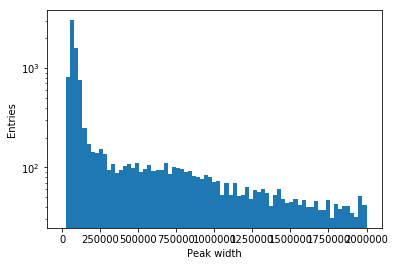

In [31]:
hist = NGwidthlist
n, bins, patches = plt.hist(hist, 75, range=(-0.5,2000000))
plt.xlabel('Peak width')
plt.ylabel('Entries')
plt.yscale('log')